# Pima Indians Diabetes Dataset

In [261]:
import warnings

import matplotlib.pyplot
import numpy
import pandas
import seaborn
from imblearn.over_sampling import ADASYN
from imblearn.pipeline import Pipeline
from scipy.stats import zscore
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split, GridSearchCV, RepeatedStratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler

random_state = 42

# 1. Obtain

- Load the dataset
- What is the dataset about?

In [262]:
diabetes_untouched = pandas.read_csv('diabetes.csv')
diabetes_untouched.describe().round(2).T

,count,mean,std,min,25%,50%,75%,max
Pregnancies,768.0,3.85,3.37,0.00,1.00,3.00,6.00,17.00
Glucose,768.0,120.89,31.97,0.00,99.00,117.00,140.25,199.00
BloodPressure,768.0,69.11,19.36,0.00,62.00,72.00,80.00,122.00
SkinThickness,768.0,20.54,15.95,0.00,0.00,23.00,32.00,99.00
Insulin,768.0,79.80,115.24,0.00,0.00,30.50,127.25,846.00
BMI,768.0,31.99,7.88,0.00,27.30,32.00,36.60,67.10
DiabetesPedigreeFunction,768.0,0.47,0.33,0.08,0.24,0.37,0.63,2.42
Age,768.0,33.24,11.76,21.00,24.00,29.00,41.00,81.00
Outcome,768.0,0.35,0.48,0.00,0.00,0.00,1.00,1.00


This dataset is about patients with diabetes.
It contains various measurements of the patients and the outcome (diabetes or not).
The goal is to predict whether a patient has diabetes or not based on the measurements.

# 2. Scrub (+ Explore)

These steps are sorted by impact on the dataset, because I want to keep the dataset as authentic as possible.
The more realistic the dataset, the more sustainable the model will be, because it is trained with real data.

- Missing data (is the count of each predictor the same?)
   - -> No missing data, since the count is the same on every feature
- Incorrect values (are there any values that are not possible?)
    - -> min of 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin' and 'BMI' is 0
        - -> replace those values with mean or median (depending on the distribution)
    - -> max of 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin' and 'BMI' is high
        - -> analyse each feature on how severe the outliers are (by looking at the distribution)
        
> Now let's address each of these issues (except for missing data, because there is none)

## 2.1 Incorrect values


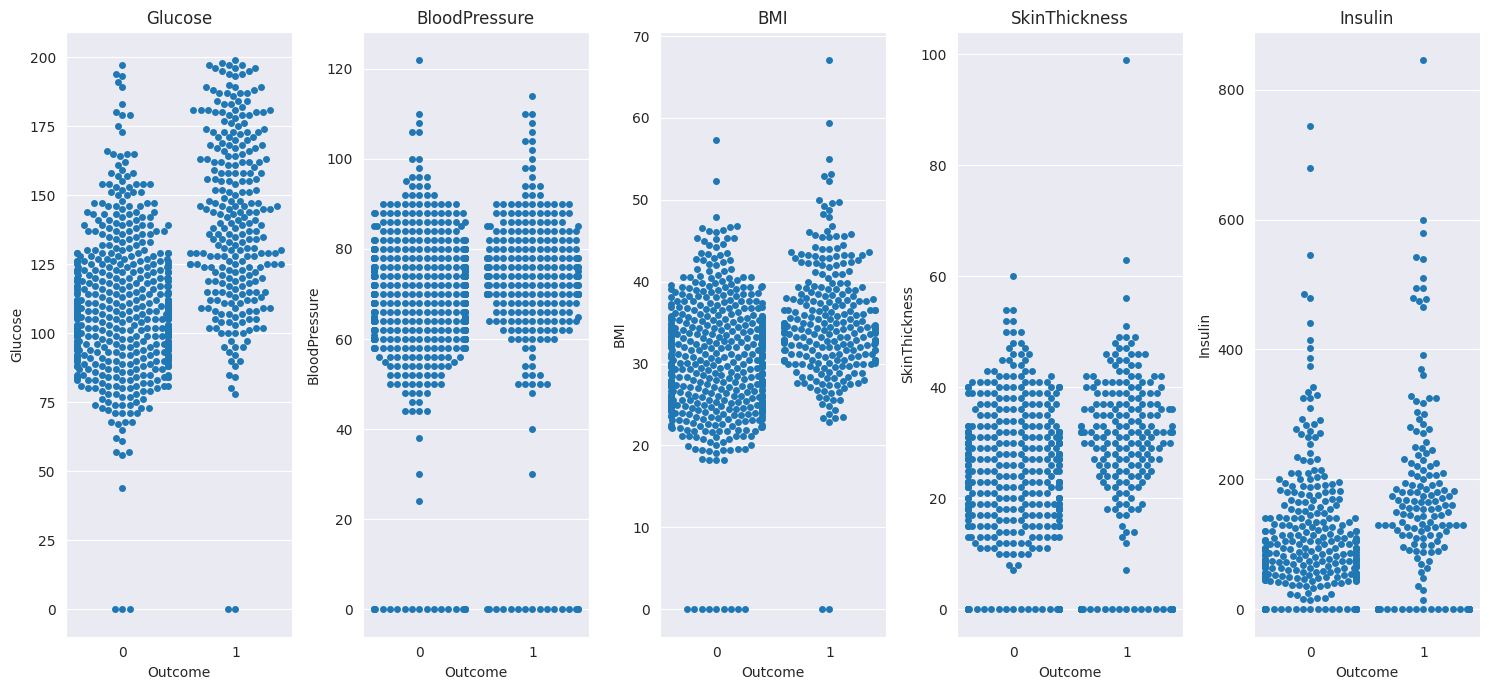

In [263]:
features_with_nans = ['Glucose', 'BloodPressure', 'BMI', 'SkinThickness', 'Insulin']

plot_checking_nans_outliers, sub_plot = matplotlib.pyplot.subplots(1, len(features_with_nans), figsize=(15, 7))
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    
    for each_iteration, each_feature in enumerate(features_with_nans):
        sub_plot[each_iteration].set_title(each_feature)
        seaborn.swarmplot(x="Outcome", y=each_feature, data=diabetes_untouched, ax=sub_plot[each_iteration])

    matplotlib.pyplot.tight_layout()
    matplotlib.pyplot.show()

> 1. the distribution of Glucose and BloodPressure is bell-shaped
>    - -> replace the missing values with the mean
> 2. the distribution of SkinThickness, Insulin and BMI is skewed
>    - -> replace the missing values with the median

## 2.1.1 Replace impossible values with mean or median

In [264]:
diabetes_nans_replaced = diabetes_untouched
diabetes_nans_replaced[features_with_nans] = diabetes_nans_replaced[features_with_nans].replace(0, numpy.NaN)

for each_feature in features_with_nans:
    if each_feature in ['Glucose', 'BloodPressure']:
        diabetes_nans_replaced[each_feature].fillna(diabetes_nans_replaced[each_feature].mean(), inplace=True)
    else:
        diabetes_nans_replaced[each_feature].fillna(diabetes_nans_replaced[each_feature].median(), inplace=True)

## 2.1.2 Removing outliers

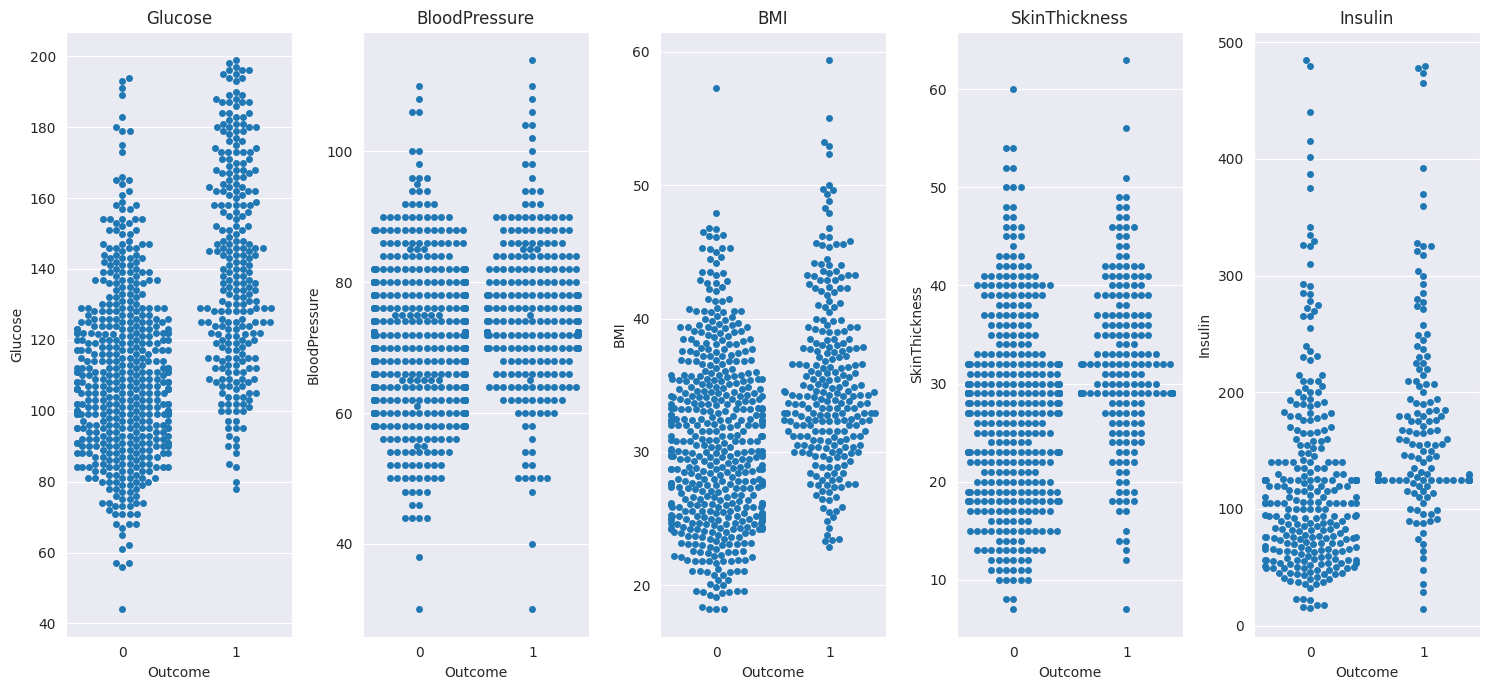

In [265]:
# gently filtering outliers with zscore
# aggressive filtering means decreasing data integrity
diabetes_nans_zscore = diabetes_nans_replaced

zscore_threshold = 4
for each_feature in features_with_nans:
    z_scores = zscore(diabetes_nans_zscore[each_feature])
    outliers_mask = (numpy.abs(z_scores) < zscore_threshold)
    diabetes_nans_zscore = diabetes_nans_zscore[outliers_mask]

diabetes_nans_zscore.reset_index(drop=True, inplace=True)

plot_checking_nans_outliers, sub_plot = matplotlib.pyplot.subplots(1, len(features_with_nans), figsize=(15, 7))
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    
    for each_iteration, each_feature in enumerate(features_with_nans):
        sub_plot[each_iteration].set_title(each_feature)
        seaborn.swarmplot(x="Outcome", y=each_feature, data=diabetes_nans_zscore, ax=sub_plot[each_iteration])

    matplotlib.pyplot.tight_layout()
    matplotlib.pyplot.show()

# 4. Model (+ Tuning)
- Splitting the dataset into train and test sets
- GridSearchCV Hyperparameter tuning + SMOTE upsampling + RepeatedKFold Cross validation
- Evaluating the model results

## 4.1 Splitting the dataset into train and test sets

First we need to determine if the dataset is balanced or not, because this will determine how we split the dataset and how we tune the models later on.

In [266]:
print(diabetes_nans_zscore['Outcome'].value_counts())

Outcome
0    495
1    258
Name: count, dtype: int64


> The dataset is not balanced, because there are more non-diabetics than diabetics
> If the imbalance is not addressed, then the model will be biased towards the majority class
--> address this in the tuning phase

In [267]:
# split the dataset into train and test sets
X = diabetes_nans_zscore.drop(["Outcome"], axis=1)
y = diabetes_nans_zscore['Outcome'].values

# use stratify=y to keep the ratio of the classes in the train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1/3, random_state=random_state, stratify=y)
X_train = StandardScaler().fit_transform(X_train)
X_test = StandardScaler().fit_transform(X_test)

## 4.3 Tune and evaluate

In [268]:
# credits: https://kiwidamien.github.io/how-to-do-cross-validation-when-upsampling-data.html
# credits: https://youtu.be/h3ARWw3uSoE?feature=shared&t=210
param_grid_knn = {
    'n_neighbors': range(24, 42, 2),
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'minkowski'],
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
    'leaf_size': range(1, 30, 5)
}

# using ADASYN to upsample (it's like SMOTE, but weights the minority class more at the decision boundaries)
# credits: https://imbalanced-learn.org/stable/over_sampling.html#ill-posed-examples
imba_pipeline_knn = Pipeline(steps=[('adasyn', ADASYN(random_state=random_state)), ('knn', KNeighborsClassifier(n_jobs=-1))])

cv=RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=random_state)
param_grid_knn__ = {'knn__' + key: param_grid_knn[key] for key in param_grid_knn}
grid_imba_knn = GridSearchCV(imba_pipeline_knn, param_grid=param_grid_knn__, cv=cv, scoring='recall', n_jobs=-1)
grid_imba_knn.fit(X_train, y_train)

print(f"Determined parameters:\n{grid_imba_knn.best_params_}\n")
print(classification_report(y_test, grid_imba_knn.predict(X_test)))

Determined parameters:
{'knn__algorithm': 'auto', 'knn__leaf_size': 1, 'knn__metric': 'euclidean', 'knn__n_neighbors': 28, 'knn__weights': 'distance'}

              precision    recall  f1-score   support

           0       0.88      0.61      0.72       165
           1       0.53      0.85      0.65        86

    accuracy                           0.69       251
   macro avg       0.71      0.73      0.69       251
weighted avg       0.76      0.69      0.70       251


> Keeping the dataset as authentic as possible, while still being able to train a model with it, is a challenge.
> At least the recall of the minority class is relatively good.